In [117]:
import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk import trigrams
from nltk import bigrams
from collections import Counter

import pandas as pd
import numpy as np
import os
import time
import csv
import json
from typing import Dict, List, Optional, Union, cast
import requests
import prepare

import seaborn as sns
import matplotlib as plt

from bs4 import BeautifulSoup

df = prepare.wrangle_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212 entries, 0 to 391
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             212 non-null    object
 1   language         212 non-null    object
 2   readme_contents  212 non-null    object
 3   stemmed          212 non-null    object
 4   lemmatized       212 non-null    object
 5   total_words      212 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 11.6+ KB


#### prepare notes-
- talk about handling nulls, decision to drop langs with < 5 records, and JN
- talk about steps to get lemmatized column

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212 entries, 0 to 391
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             212 non-null    object
 1   language         212 non-null    object
 2   readme_contents  212 non-null    object
 3   stemmed          212 non-null    object
 4   lemmatized       212 non-null    object
 5   total_words      212 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 11.6+ KB


In [4]:
df.language.value_counts()

JavaScript    55
HTML          39
Python        39
TypeScript    21
Java          17
Dart          12
R             12
CSS            9
Swift          8
Name: language, dtype: int64

#### show counts and percentage of languages

- put this in function

In [47]:
langs = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
langs.columns = ['counts', 'percent']
langs

,counts,percent
JavaScript,55,0.259434
HTML,39,0.183962
Python,39,0.183962
TypeScript,21,0.099057
Java,17,0.080189
Dart,12,0.056604
R,12,0.056604
CSS,9,0.042453
Swift,8,0.037736


In [168]:
ADDITIONAL = ['The', 'I', 'This', 'mental', 'health', 'Mental', 'Health', 'run', 'page', 'use', '1', 'br', 'user', '3', 'install', '2', 'website',
       'start', 'time', 'p', 'make', 'feature']
def clean(readme_contents):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL
    text = (unicodedata.normalize('NFKD', readme_contents)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [169]:
JavaScript_words = clean(' '.join(df[df.language == 'JavaScript'].readme_contents))
HTML_words = clean(' '.join(df[df.language == 'HTML'].readme_contents))
Python_words = clean(' '.join(df[df.language == 'Python'].readme_contents))
TypeScript_words = clean(' '.join(df[df.language == 'TypeScript'].readme_contents))
Java_words = clean(' '.join(df[df.language == 'Java'].readme_contents))
Dart_words = clean(' '.join(df[df.language == 'Dart'].readme_contents))
CSS_words = clean(' '.join(df[df.language == 'CSS'].readme_contents))
R_words = clean(' '.join(df[df.language == 'R'].readme_contents))
Swift_words = clean(' '.join(df[df.language == 'Swift'].readme_contents))
all_words = clean(' '.join(df.readme_contents))

In [170]:
df['total_words'] = df['lemmatized'].str.split().str.len()

<AxesSubplot:>

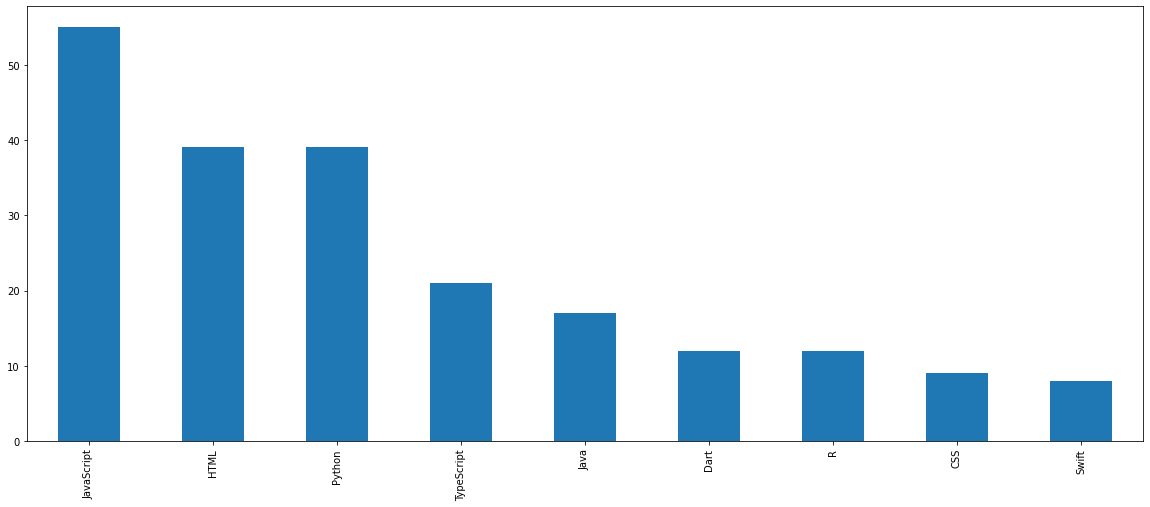

In [51]:
df.language.value_counts().plot(kind='bar')

<AxesSubplot:xlabel='language'>

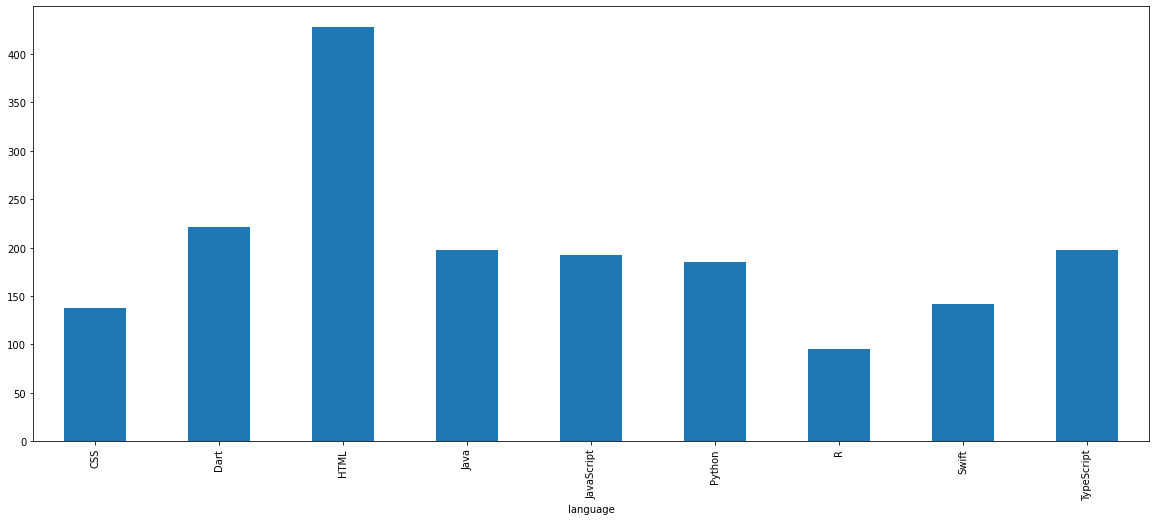

In [171]:
df.total_words.groupby(df.language).mean().plot(kind='bar')

In [172]:
df.total_words.quantile(.66)

188.04000000000008

In [173]:
conditions = [(df.total_words > 188),
              (df.total_words >= 77) & (df.total_words <= 188),
              (df.total_words < 77)]
choices = ['high_count', 'med_count', 'low_count']

df['count_bin'] = np.select(conditions, choices)

In [174]:
df_plot = df.groupby(['language', 'count_bin']).size().reset_index().pivot(columns='count_bin', index='language', values=0)

<AxesSubplot:xlabel='language'>

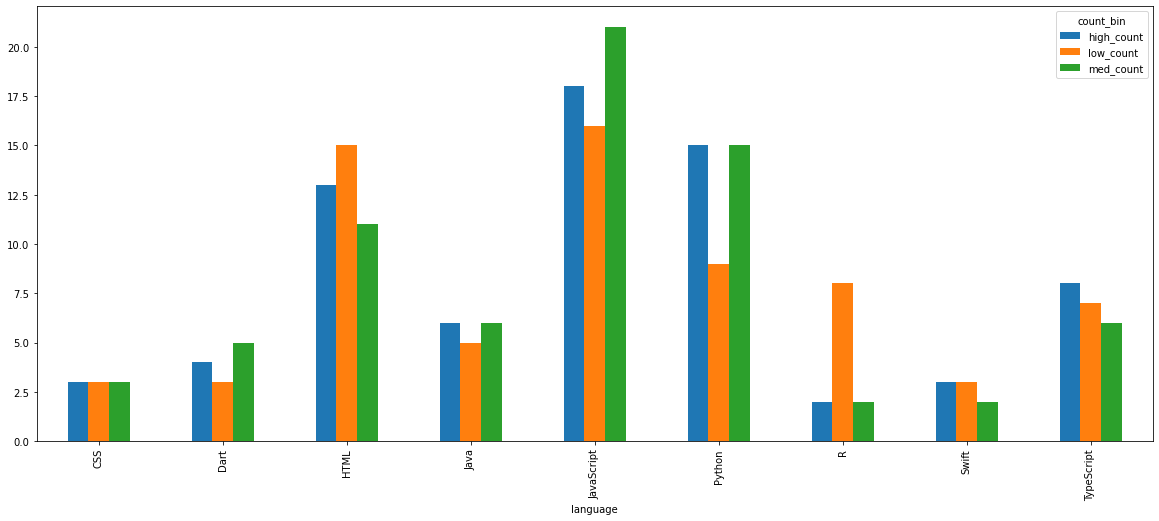

In [55]:
df_plot.plot(kind='bar')

In [123]:
df.language.value_counts()

JavaScript    55
HTML          39
Python        39
TypeScript    21
Java          17
Dart          12
R             12
CSS            9
Swift          8
Name: language, dtype: int64

In [175]:
JavaScript_freq = pd.Series(JavaScript_words).value_counts()
HTML_freq = pd.Series(HTML_words).value_counts()
Python_freq = pd.Series(Python_words).value_counts()
TypeScript_freq = pd.Series(TypeScript_words).value_counts()
Java_freq = pd.Series(Java_words).value_counts()
Dart_freq = pd.Series(Dart_words).value_counts()
CSS_freq = pd.Series(CSS_words).value_counts()
R_freq = pd.Series(R_words).value_counts()
Swift_freq = pd.Series(Swift_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [176]:
word_counts = (pd.concat([all_freq, JavaScript_freq, HTML_freq, Python_freq, TypeScript_freq,
                    Java_freq, Dart_freq, CSS_freq, R_freq, Swift_freq], axis=1, sort=True)
                .set_axis(['all', 'JavaScript', 'HTML', 'Python', 'TypeScript', 'Java', 'Dart', 'CSS', 'R', 'Swift'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,JavaScript,HTML,Python,TypeScript,Java,Dart,CSS,R,Swift
0,40,16,16,0,8,0,0,0,0,0
000,2,0,1,0,0,0,1,0,0,0
0000,1,0,1,0,0,0,0,0,0,0
00000,2,0,2,0,0,0,0,0,0,0
0001,10,0,9,1,0,0,0,0,0,0


In [177]:
word_counts.sort_values(by='all', ascending=False).head(20)

,all,JavaScript,HTML,Python,TypeScript,Java,Dart,CSS,R,Swift
project,330,69,88,34,39,35,33,20,9,3
app,283,83,26,8,56,32,45,4,1,28
help,254,38,96,30,35,8,28,8,2,9
data,245,43,46,79,16,22,14,0,20,5
img,238,36,51,35,17,32,37,20,1,9
using,205,57,39,50,7,25,8,6,7,6
people,196,29,81,12,37,4,15,9,1,8
used,193,42,101,22,8,5,2,6,4,3
user,166,47,56,14,11,18,12,1,0,7
want,159,23,86,8,16,9,8,5,0,4


In [127]:
word_counts.sort_values(by='all', ascending=False).head(20)

,all,JavaScript,HTML,Python,TypeScript,Java,Dart,CSS,R,Swift
page,307,69,193,2,19,10,3,8,0,3
1,232,51,112,19,17,10,12,6,1,4
br,216,48,122,11,10,13,10,2,0,0
use,205,64,60,30,16,13,8,10,1,3
used,193,42,101,22,8,5,2,6,4,3
run,193,74,21,37,19,7,4,22,7,2
user,166,47,56,14,11,18,12,1,0,7
2,165,42,54,19,18,9,11,6,2,4
3,163,46,47,26,13,8,12,7,0,4
website,162,39,100,1,9,1,2,9,1,0


In [178]:
js_top = word_counts.sort_values(by='JavaScript', ascending=False).head(20)
html_top = word_counts.sort_values(by='HTML', ascending=False).head(20)
python_top = word_counts.sort_values(by='Python', ascending=False).head(20)
typescript_top = word_counts.sort_values(by='TypeScript', ascending=False).head(20)
java_top = word_counts.sort_values(by='Java', ascending=False).head(20)
dart_top = word_counts.sort_values(by='Dart', ascending=False).head(20)
css_top = word_counts.sort_values(by='CSS', ascending=False).head(20)
r_top = word_counts.sort_values(by='R', ascending=False).head(20)
swift_top = word_counts.sort_values(by='Swift', ascending=False).head(20)

In [179]:
top_words = (pd.concat([js_top, html_top, python_top, typescript_top, java_top,
                    dart_top, css_top, r_top, swift_top], axis=0, sort=True)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

top_words.head()

,CSS,Dart,HTML,Java,JavaScript,Python,R,Swift,TypeScript,all
app,4,45,26,32,83,8,1,28,56,283
npm,3,0,5,0,69,0,0,0,10,87
project,20,33,88,35,69,34,9,3,39,330
using,6,8,39,25,57,50,7,6,7,205
team,3,5,19,0,53,1,0,1,6,88


In [180]:
top_words= top_words.drop(columns=['all'])

In [110]:
top_words
#, 'PHP', 'C++']

,CSS,Dart,HTML,Java,JavaScript,Python,R,Swift,TypeScript
user,2,26,197,67,98,34,0,18,24
app,4,45,26,32,83,8,1,28,56
run,22,4,21,7,74,37,7,2,19
project,20,33,88,35,69,34,9,3,39
page,8,3,193,10,69,2,0,3,19
...,...,...,...,...,...,...,...,...,...
time,3,5,60,19,33,24,0,7,11
track,1,1,1,4,9,4,0,7,6
using,6,8,39,25,57,50,7,6,7
moodsnap,0,0,0,0,0,0,0,6,0


In [181]:
tops = top_words[top_words.index.value_counts() > 2]

/var/folders/s4/hmz6ljm533vgpm_bhv59yw0m0000gn/T/ipykernel_69571/3058113156.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tops = top_words[top_words.index.value_counts() > 2]


In [166]:
tops.index.unique()

Index(['run', 'page', 'use', '1', 'br', 'user', '3', 'install', '2', 'website',
       'start', 'time', 'p', 'make', 'feature'],
      dtype='object')

In [113]:
tops.groupby(tops.index).sum()

,CSS,Dart,HTML,Java,JavaScript,Python,R,Swift,TypeScript
help,48,168,576,48,228,180,12,54,210
project,160,264,704,280,552,272,72,24,312
user,14,182,1379,469,686,238,0,126,168


In [182]:
most_freq_155 = word_counts[word_counts['all'] > 155] 
most_freq_155 = most_freq_155[most_freq_155['all'] < 180]
most_freq_180 = word_counts[word_counts['all'] >= 180]
most_freq_180 = most_freq_180[most_freq_180['all'] < 220]
most_freq = word_counts[word_counts['all'] >= 220]

In [ ]:
most_freq.head()

In [183]:
word_perc = pd.DataFrame()
for col in most_freq.columns:
    word_perc = word_perc.append(most_freq[col].sort_values(ascending=False)/most_freq[col].sum())

word_perc_155 = pd.DataFrame()
for col in most_freq_155.columns:
    word_perc_155 = word_perc_155.append(most_freq_155[col].sort_values(ascending=False)/most_freq_155[col].sum())
    
word_perc_180 = pd.DataFrame()
for col in most_freq_180.columns:
    word_perc_180 = word_perc_180.append(most_freq_180[col].sort_values(ascending=False)/most_freq_180[col].sum())

In [ ]:
word_perc

<AxesSubplot:>

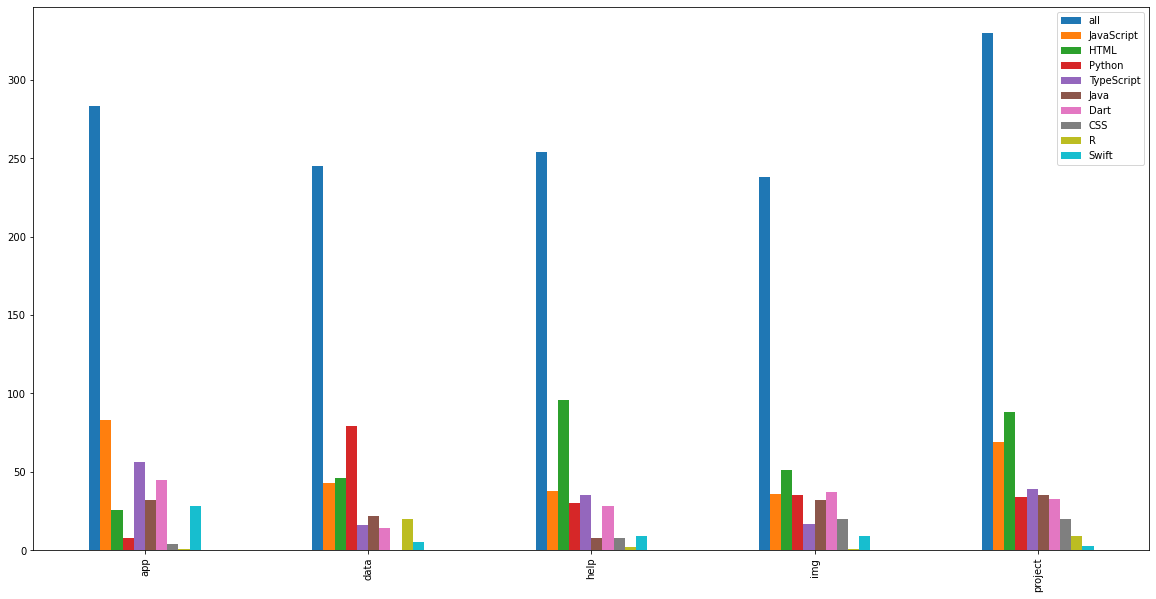

In [184]:
plt.rcParams["figure.figsize"] = (20,10)
most_freq.plot(kind='bar')

<AxesSubplot:>

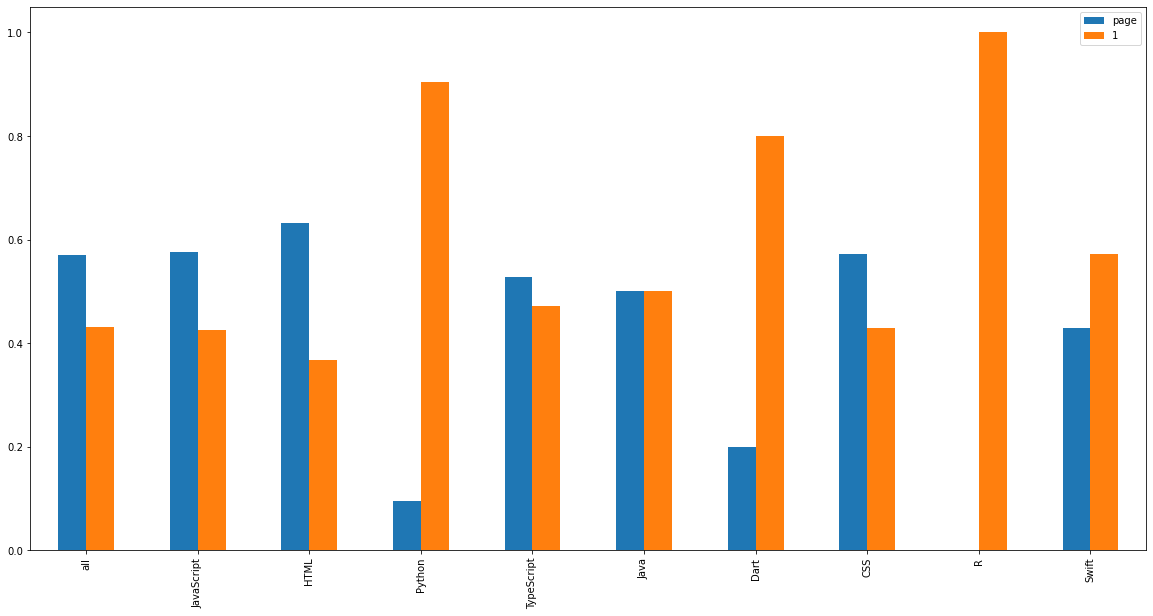

In [134]:
plt.rcParams["figure.figsize"] = (20,10)
word_perc.plot(kind='bar')

In [185]:
word_perc_T = word_perc.T
word_perc_155_T = word_perc_155.T
word_perc_180_T = word_perc_180.T

to look at similarities, we simple look at bars w similar heights. That will show they have a similar distribution of that specific word

<AxesSubplot:>

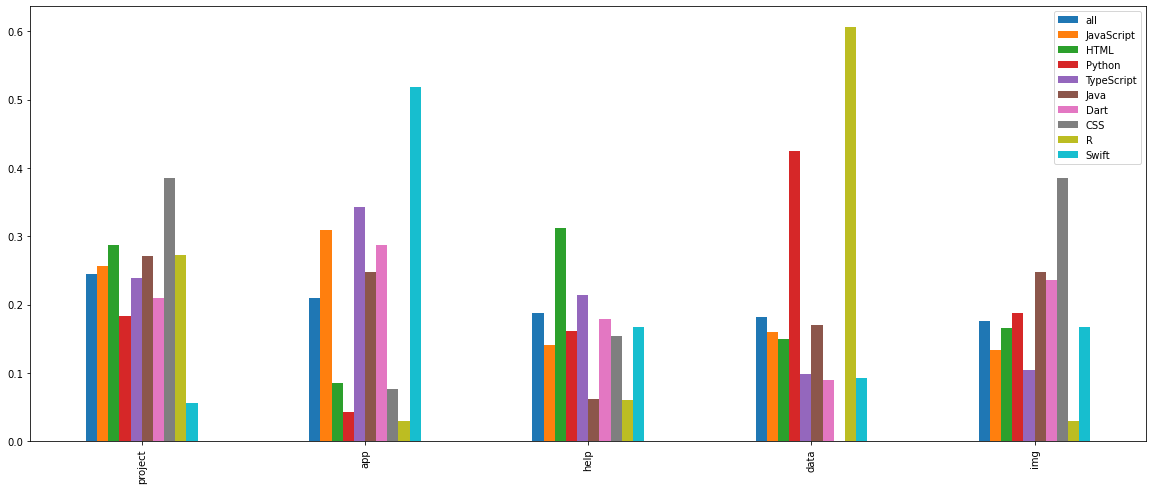

In [186]:
plt.rcParams["figure.figsize"] = (20,8)
word_perc_T.plot(kind='bar')

<AxesSubplot:>

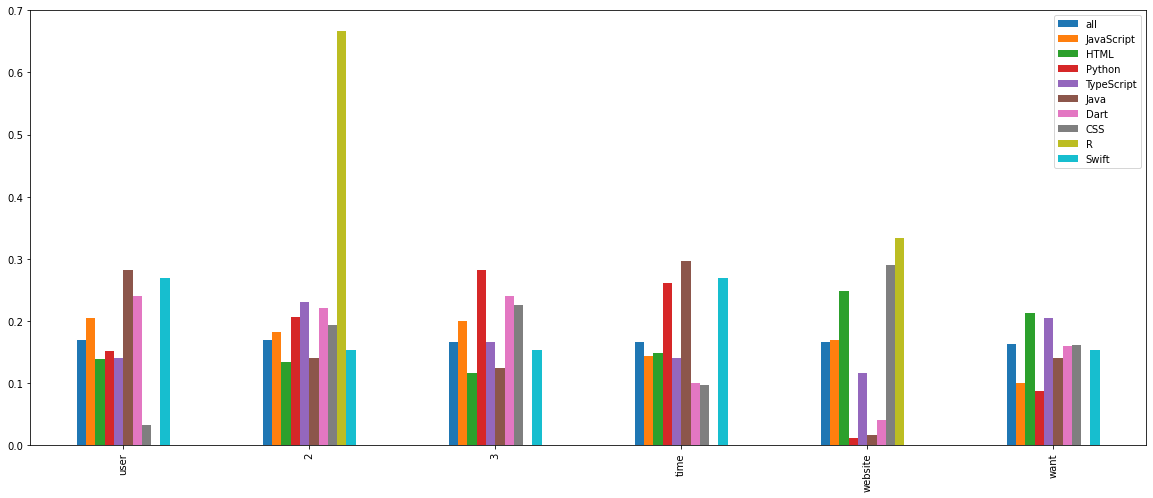

In [137]:
plt.rcParams["figure.figsize"] = (20,8)
word_perc_155_T.plot(kind='bar')

In [ ]:
word_perc_T

<AxesSubplot:>

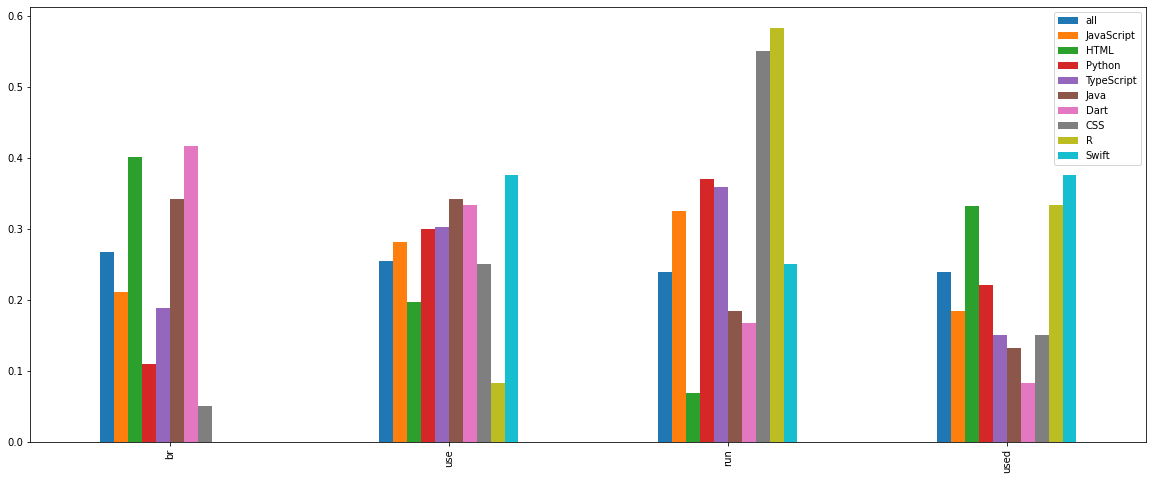

In [138]:
plt.rcParams["figure.figsize"] = (20,8)
word_perc_180_T.plot(kind='bar')

In [139]:
langs = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
langs.columns = ['counts', 'percent']
langs

,counts,percent
JavaScript,55,0.259434
HTML,39,0.183962
Python,39,0.183962
TypeScript,21,0.099057
Java,17,0.080189
Dart,12,0.056604
R,12,0.056604
CSS,9,0.042453
Swift,8,0.037736


In [189]:
df

,repo,language,readme_contents,stemmed,lemmatized,total_words,count_bin
0,dreamingechoes/awesome-mental-health,HTML,"\n<p align=""center""><img src=""./media/logo.png...",aboutsparkl curat list awesom articl websit re...,aboutsparkles curated list awesome article web...,1140,high_count
1,Flaque/quirk,TypeScript,🚧🚧🚧\n\n**Quirk is no longer being maintained.*...,quirk longer maintainedquirk start littl thing...,quirk longer maintainedquirk started little th...,1061,high_count
4,sepandhaghighi/nafas,Python,"<div align=""center"">\n<img src=""https://github...",nafa &#9; tabl content overview instal usag is...,nafas &#9; table content overview installation...,351,high_count
5,youarerad/youareradweb,TypeScript,"<div align=""center""><img src=""https://res.clou...",welcom rise disord ' websit repow nonprofit co...,welcome rise disorder ' website repowe nonprof...,83,med_count
8,chroline/well_app,Dart,![The Well App](thumbnail.png)\n\n<div align='...,well appthumbnailpng quick link well app avail...,well appthumbnailpng quick link well app avail...,320,high_count
...,...,...,...,...,...,...,...
381,EdwardRees/Self-Care-Project,TypeScript,# Self Care Project\n\nWhat used to be a Menta...,self care projectwhat use mental health projec...,self care projectwhat used mental health proje...,49,low_count
385,sumantchirde/Mental-Health-NLP-project,Python,# Mental health assessment by NLP and ML usin...,mental health assess nlp ml use tensorflownowa...,mental health assessment nlp ml using tensorfl...,88,med_count
386,Levodex/RipplerPy,JavaScript,## About\n* \n* (Read github/bitbucket descrip...,read githubbitbucket descript copyright notice...,read githubbitbucket description copyright not...,155,med_count
388,acfromspace/soulstone,HTML,"<!-- HEADING -->\n\n<h1 align=""center"">soulsto...",soulstoneperson reflect thought one ' selfswee...,soulstonepersonal reflection thought one ' sel...,15,low_count


In [188]:
trigrams = [x for x in df['lemmatized'] for x in trigrams(x.split())]
trigrams

TypeError: 'list' object is not callable

In [141]:
tri_counts = Counter(trigrams)
print (tri_counts)

Counter({("'", 'section', "'"): 34, ('nbsp', 'nbsp', 'nbsp'): 27, ("'", 'help', "'"): 26, ("'", 'home', "'"): 25, ('mental', 'health', 'issue'): 23, ('section', "'", 'help'): 22, ('mental', 'health', 'tech'): 21, ("'", 'spread', 'word'): 21, ('spread', 'word', "'"): 21, ('home', "'", 'page'): 17, ("'", 'sign', "'"): 17, ("'", 'page', 'user'): 17, ("'", 'mental', 'health'): 16, ('mental', 'health', 'disorder'): 16, ("'", 'help', 'others'): 16, ('help', 'others', "'"): 16, ('front', 'line', 'worker'): 16, ('mental', 'health', 'problem'): 15, ('help', "'", 'page'): 15, ('word', "'", 'page'): 15, ("'", 'educate', "'"): 14, ('mental', 'health', 'awareness'): 13, ("'", 'resource', "'"): 13, ('member', 'github', 'team'): 12, ('github', 'team', 'member'): 12, ('team', 'member', 'social'): 12, ("'", 'lex', "'"): 11, ('mental', 'health', 'condition'): 11, ('resource', "'", 'section'): 11, ('showing', 'first', 'part'): 11, ('first', 'part', "'"): 11, ('hide', 'feed', 'home'): 10, ('feed', 'home',

In [25]:
top = tri_counts.most_common(10)
print (top)

[(("'", 'section', "'"), 34), (('nbsp', 'nbsp', 'nbsp'), 27), (("'", 'help', "'"), 26), (("'", 'home', "'"), 25), (('mental', 'health', 'issue'), 23), (('section', "'", 'help'), 22), (('mental', 'health', 'tech'), 21), (("'", 'spread', 'word'), 21), (('spread', 'word', "'"), 21), (('home', "'", 'page'), 17)]


In [26]:
df['bigrams'] = all_words.apply(lambda row: list(nltk.ngrams(row, 2)))

AttributeError: 'list' object has no attribute 'apply'

In [27]:
from nltk.util import ngrams

n = 2
bigrams = all_words.apply(lambda x:" ".join(x for x in x.split(), n))

SyntaxError: Generator expression must be parenthesized (3930107196.py, line 4)

In [ ]:
df

In [28]:
top_20_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(20))

top_20_bigrams.head(20)

(mental, health)      431
(br, br)               73
(img, src)             48
(home, page)           47
(nbsp, nbsp)           46
(team, member)         44
(p, aligncenter)       44
(git, clone)           34
(image, showing)       33
(social, medium)       31
(td, aligncentera)     30
(aligncenter, img)     28
(open, source)         28
(navigation, bar)      25
(mental, illness)      25
(front, line)          25
(health, issue)        25
(line, worker)         24
(npm, install)         24
(page, user)           24
dtype: int64

In [143]:
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint

In [190]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report


tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.stemmed)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)


In [191]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 69.82%
---
Confusion Matrix
actual      CSS  Dart  HTML  Java  JavaScript  Python  R  Swift  TypeScript
predicted                                                                  
HTML          0     2    30     1           0       0  1      0           0
Java          0     0     0     2           0       0  0      0           0
JavaScript    5     8     1    10          44       0  4      5           9
Python        2     0     0     0           0      31  2      1           0
R             0     0     0     0           0       0  3      0           0
TypeScript    0     0     0     0           0       0  0      0           8
---
              precision    recall  f1-score   support

         CSS       0.00      0.00      0.00         7
        Dart       0.00      0.00      0.00        10
        HTML       0.88      0.97      0.92        31
        Java       1.00      0.15      0.27        13
  JavaScript       0.51      1.00      0.68        44
      Python       0.86  

/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [192]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 30.23%
---
Confusion Matrix
actual      CSS  Dart  HTML  Java  JavaScript  Python  R  Swift  TypeScript
predicted                                                                  
HTML          0     0     1     0           2       0  0      0           0
JavaScript    2     2     7     4           9       5  2      2           4
Python        0     0     0     0           0       3  0      0           0
---
              precision    recall  f1-score   support

         CSS       0.00      0.00      0.00         2
        Dart       0.00      0.00      0.00         2
        HTML       0.33      0.12      0.18         8
        Java       0.00      0.00      0.00         4
  JavaScript       0.24      0.82      0.38        11
      Python       1.00      0.38      0.55         8
           R       0.00      0.00      0.00         2
       Swift       0.00      0.00      0.00         2
  TypeScript       0.00      0.00      0.00         4

    accuracy                        

/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [195]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.stemmed)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)

tree = DecisionTreeClassifier(max_depth=10, random_state=123)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_train, y_train) * 100:.2f}%')

Accuracy Score: 56.80%


In [196]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report
from sklearn import tree

In [197]:
cv = CountVectorizer()
X = cv.fit_transform(df.stemmed)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)

tree = DecisionTreeClassifier(max_depth=12, random_state=13)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_test, y_test) * 100:.2f}%')

Accuracy Score: 44.19%


In [164]:
cv = CountVectorizer(ngram_range=(2, 2))
X = cv.fit_transform(df.lemmatized)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

tree = DecisionTreeClassifier(max_depth=7, random_state=13)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_test, y_test) * 100:.2f}%')

Accuracy Score: 39.53%


In [ ]:
cv = CountVectorizer(ngram_range=(4, 4))
X = cv.fit_transform(df.stemmed)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=13)

tree = DecisionTreeClassifier(max_depth=7, random_state=13)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_val, y_val) * 100:.2f}%')

In [ ]:
all_words = re.sub(r'[^\w\s]', '', (' '.join(df.lemmatized))).split()
all_freq = pd.Series(all_words).value_counts()
    
    mask = all_freq > 1
    all_not_unique = list(all_freq[mask].index)

In [ ]:
bigrams = df.apply(lambda x : list(nltk.ngrams(x, 2)))

In [ ]:
bigrams

In [ ]:
def make_word_list(df):
    """ creates a list of every not unique word in dataframe"""
    all_words = re.sub(r'[^\w\s]', '', (' '.join(df.lemmatized))).split()
    all_freq = pd.Series(all_words).value_counts()
    
    mask = all_freq > 1
    all_not_unique = list(all_freq[mask].index)
    
    return all_not_unique

def finding_non_single_words(x):
    """finds all words in column that appear in df more than one time
    will be used to make a column that counts words that appear more than once"""
    all_not_unique = make_word_list(df)
    l = []
    for w in x:
        if w in all_not_unique:
            l.append(w)
    return l


def feature_engineering(df):
    """creates calculated columns for df subsetted by type of column"""
    
    #list making features 
    df['word_list'] = df.lemmatized.apply(lambda x: re.sub(r'[^\w\s]', '', x).split())
    df['unique_words'] = df.word_list.apply(lambda x: pd.Series(x).unique())
    df['non_single_words'] = df.word_list.apply(lambda x: finding_non_single_words(x))

    # counting
    df['word_count_simple'] = df.lemmatized.str.count(" ") + 1
    df['word_count'] = df.word_list.apply(lambda x: len(x))
    df['unique_count'] = df.unique_words.apply(lambda x: len(x))
    df['non_single_count'] = df.non_single_words.apply(lambda x: len(x))

    # calculating
    df['percent_unique'] = (df.unique_count / df.word_count)
    df['percent_repeat'] = (1 - df.unique_count / df.word_count)
    df['percent_one_word'] = df.word_list.apply(lambda x: (pd.Series(x).value_counts() == 1).mean())
    df['percent_non_single'] = (df.non_single_count / df.word_count)

    return df

# new dataframes

def language_series(df):
    """makes df with words and frequency of words for each programming language"""

    all_words = (' '.join(df.lemmatized))
    all_words = re.sub(r'[^\w\s]', '', all_words).split()
    all_freq = pd.Series(all_words).value_counts()

    php_words = (' '.join(df[df.language == 'PHP'].lemmatized))
    php_words = re.sub(r'[^\w\s]', '', php_words).split()
    php_freq = pd.Series(php_words).value_counts()

    python_words = (' '.join(df[df.language == 'Python'].lemmatized))
    python_words = re.sub(r'[^\w\s]', '', python_words).split()
    python_freq = pd.Series(python_words).value_counts()

    java_words = (' '.join(df[df.language == 'Java'].lemmatized))
    java_words = re.sub(r'[^\w\s]', '', java_words).split()
    java_freq = pd.Series(java_words).value_counts()

    js_words = (' '.join(df[df.language == 'JavaScript'].lemmatized))
    js_words = re.sub(r'[^\w\s]', '', js_words).split()
    js_freq = pd.Series(js_words).value_counts()

    freq_df = pd.DataFrame({'all': all_freq,
                       'php': php_freq,
                       'python': python_freq,
                       'java': java_freq,
                       'java_script': js_freq
                        })
    freq_df = freq_df.fillna(0)
    freq_df = freq_df.astype(int)

    return freq_df

def make_language_df(df=df):
    """creates a data frame of words in rows"""
    freq_df = language_series(df)
    
    freq_list = freq_df['all'].sort_values(ascending = False).head(15).index
    
    df_js = df[0:200]
    df_python = df[200:400]
    df_java = df[400:600]
    df_php= df[600:800]
    
    all_list = []
    js_list = []
    python_list = []
    php_list = []
    java_list = []
    
    for i in freq_list:
        v = len(pd.DataFrame({'loc_index' :df[df.lemmatized.apply(lambda x: len(re.findall(i, x))) > 0].index}))
        all_list.append(v)
    
        js = len(pd.DataFrame({'loc_index' :df_js[df_js.lemmatized.apply(lambda x: len(re.findall(i, x))) > 0].index}))
        js_list.append(js)
   
        py = len(pd.DataFrame({'loc_index' :df_python[df_python.lemmatized.apply(lambda x: len(re.findall(i, x))) > 0].index}))
        python_list.append(py)
    
        php = len(pd.DataFrame({'loc_index' :df_php[df_php.lemmatized.apply(lambda x: len(re.findall(i, x))) > 0].index}))
        php_list.append(php)
    
        jv = len(pd.DataFrame({'loc_index' :df_java[df_java.lemmatized.apply(lambda x: len(re.findall(i, x))) > 0].index}))
        java_list.append(jv)
        
    language_df = pd.DataFrame({'word': freq_list,
                         'all_languages': all_list,
                        'javascript': js_list,
                         'python': python_list,
                        'php': php_list,
                            'java': java_list
                        })
        
    return language_df